In [1]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Input, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow import keras

In [2]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

trainit = datagen.flow_from_directory("../final_dataset2/training", 
                                      target_size=(224, 224), 
                                      class_mode = "binary", 
                                      batch_size=32)

testit = datagen.flow_from_directory("../final_dataset2/testing",
                                      shuffle=False,
                                      target_size=(224, 224), 
                                      class_mode = "binary", 
                                      batch_size=32)

valit = datagen.flow_from_directory("../final_dataset2/validation", 
                                      shuffle=False,
                                      target_size=(224, 224), 
                                      class_mode = "binary", 
                                      batch_size=32)

Found 1600 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [3]:
model = MobileNet(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
model.summary()

17235968/17225924 [==============================] - 40s 2us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 3

In [4]:
flattened = GlobalMaxPooling2D()(model.layers[-1].output)
hidden = Dense(64, activation="relu")(flattened)
dropout = Dropout(0.5)(hidden)
normalized = BatchNormalization()(dropout)
output = Dense(1, activation="sigmoid")(normalized)
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [5]:
model.compile(optimizer='adam', 
              loss="binary_crossentropy", 
              metrics=["accuracy"]
)

In [8]:
history = model.fit(trainit, validation_data=(valit), epochs=5)

Epoch 1/5
50/50 [==============================] - 303s 6s/step - loss: 0.0683 - accuracy: 0.9819 - val_loss: 0.1187 - val_accuracy: 0.9700
Epoch 2/5
50/50 [==============================] - 309s 6s/step - loss: 0.0566 - accuracy: 0.9831 - val_loss: 0.0710 - val_accuracy: 0.9775
Epoch 3/5
50/50 [==============================] - 309s 6s/step - loss: 0.0340 - accuracy: 0.9912 - val_loss: 0.1417 - val_accuracy: 0.9550
Epoch 4/5
50/50 [==============================] - 315s 6s/step - loss: 0.0391 - accuracy: 0.9887 - val_loss: 0.0503 - val_accuracy: 0.9800
Epoch 5/5
50/50 [==============================] - 311s 6s/step - loss: 0.0538 - accuracy: 0.9806 - val_loss: 0.0300 - val_accuracy: 0.9900


In [9]:
scores = model.evaluate(testit)

38/38 [==============================] - 87s 2s/step - loss: 0.0372 - accuracy: 0.9850


In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [12]:
import matplotlib.pyplot as plt

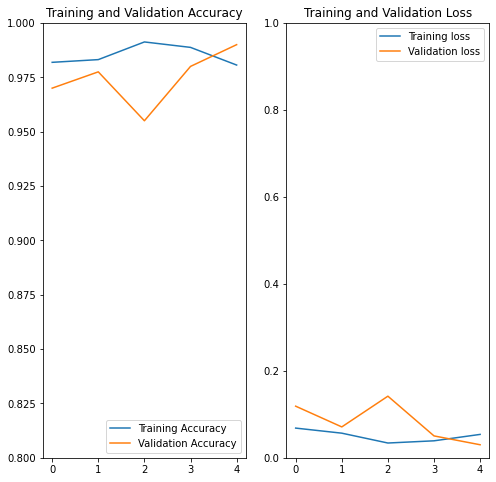

In [35]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(5), acc, label ='Training Accuracy')
plt.plot(range(5), val_acc, label='Validation Accuracy')
plt.ylim(0.80, 1)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(5), loss, label ='Training loss')
plt.plot(range(5), val_loss, label='Validation loss')
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
model.save("../saved_models/lacuna_combined.h5")

In [37]:
prediction = model.predict(testit) # predict probabilities
y_pred = [int(round(i[0])) for i in prediction] # converting probabilities to binary outputs

In [38]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [39]:
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=pyplot.cm.Blues
):
    
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, "{:0.2f}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')

In [41]:
target_names = ["fall_armyworm", "healthy"]

In [42]:
print("Confusion Matrix")
conf_matrix = confusion_matrix(testit.classes, y_pred)
print(conf_matrix)

Confusion Matrix
[[594   6]
 [ 12 588]]


Confusion matrix, without normalization
[[594   6]
 [ 12 588]]


<function matplotlib.pyplot.show(close=None, block=None)>

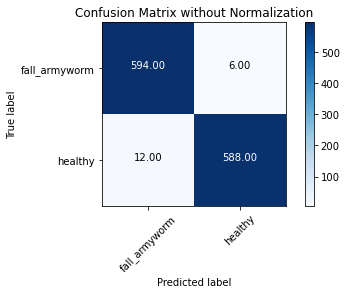

In [49]:
pyplot.figure(1)
plot_confusion_matrix(conf_matrix, classes=target_names, normalize=False, title="Confusion Matrix without Normalization")
pyplot.show

In [48]:
print(classification_report(testit.classes, y_pred, target_names=target_names))

               precision    recall  f1-score   support

fall_armyworm       0.98      0.99      0.99       600
      healthy       0.99      0.98      0.98       600

     accuracy                           0.98      1200
    macro avg       0.99      0.98      0.98      1200
 weighted avg       0.99      0.98      0.98      1200

